In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')

In [5]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_id': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_id': 'num_products'})
df_ord = df_ord.merge(df_items, on=['order_id'], how='left')

In [6]:
df_braze = pd.read_csv('../data/braze_customers.csv')
df_braze = df_braze[['customer_id', 'email_subscribe', 'push_subscribe']]
df_braze.email_subscribe = df_braze.email_subscribe.isin(['subscribed', 'opted_in'])
df_braze.push_subscribe = df_braze.push_subscribe.isin(['subscribed', 'opted_in'])

df_ord = df_ord.merge(df_braze, on='customer_id', how='left')
df_ord.email_subscribe = df_ord.email_subscribe.fillna(False)
df_ord.push_subscribe = df_ord.push_subscribe.fillna(False)

In [7]:
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord.order_created_datetime = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_day'] = (df_ord.order_created_datetime - datetime(2017, 1, 1)).dt.days
df_ord['order_weekday'] = (df_ord.order_created_datetime).dt.weekday
df_ord['order_month'] = (df_ord.order_created_datetime).dt.month

In [8]:
df_ord = df_ord.drop_duplicates()

In [9]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

In [10]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,completed_orders,last_order_created_datetime,quantity,num_products,email_subscribe,push_subscribe,days_since_last_seen,order_day,order_weekday,order_month
0,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,583,1,8
1,DE-B-20696,5a1ee6e144770903118b466f,5abe2737467709f94e8b4695,52.491111,13.429692,2018-04-04 06:00:00,2018-04-04 07:00:00,12047,completed,2018-03-30 14:01:59,...,21,2018-09-26 10:18:16,2.0,1.0,True,True,3,453,4,3
2,DE-B-72139,5a1ee6e144770903118b466f,5b8a56d5ee1b6a373e38f39c,52.491111,13.429692,2018-09-03 10:00:00,2018-09-03 11:00:00,12047,completed,2018-09-01 11:07:33,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,608,5,9
3,DE-B-87918,5a1ee6e144770903118b466f,5afc6c33c3436275d6724815,52.491111,13.429692,2018-05-22 07:00:00,2018-05-22 08:00:00,12047,completed,2018-05-16 19:36:51,...,21,2018-09-26 10:18:16,3.0,1.0,True,True,3,500,2,5
4,DE-C-27253,5a1ee6e144770903118b466f,5b20cb79ee1b6a090e115c25,52.491111,13.429692,2018-06-16 12:00:00,2018-06-16 13:00:00,12047,completed,2018-06-13 09:44:57,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,528,2,6


In [11]:
sorted(df_ord.columns)

['activity_state',
 'aov',
 'churn_factor',
 'city',
 'cluster',
 'cluster_name',
 'completed_orders',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_order',
 'days_since_last_seen',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'email_subscribe',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'frequency',
 'gender',
 'internal_rescheduled',
 'last_order',
 'last_order_created_datetime',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'num_products',
 'order_created_datetime',
 'order_day',
 'order_db_id',
 'order_id',
 'order_month',
 'order_num',
 'order_state',
 'order_weekday',
 'order_x',
 'order_y',
 'origin',
 'pickup_timeslot_from_datetime',
 'pickup_timeslot_to_datetime',
 'pickup_zip',
 'product_DC',
 'product_HH',
 'product_LA',
 'product_WF',
 'product_combinations',
 'product_type',
 'punctual_5min_

### Completed Dataset

In [12]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['completed_orders'] = df_comp.groupby(['customer_db_id']).transform('count')
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [13]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

# Customer Lifetime
Created dataframe for customer lifetime

In [14]:
df_life = df_comp.copy()
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8

df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'
df_life['voucher_ratio'] = (df_life.voucher_value / df_life.revenue_voucher).round(1)

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['returned_voucher'] = df_life.groupby('customer_id').voucher_value.shift(-1).fillna(0)
df_life['returned_voucher'] = (df_life.returned_voucher > 0)
df_life['over_frequency'] = df_life.churn_factor >= 1
df_life['freq_median'] = df_life.groupby('order_day')['frequency'].transform('median')

In [15]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

### Sample Customer

In [16]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    

    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [17]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2)]['customer_id'].sample(3)
samples

17881    CUS-N8798789
13828    CUS-E8962811
4888     CUS-L8514871
Name: customer_id, dtype: object

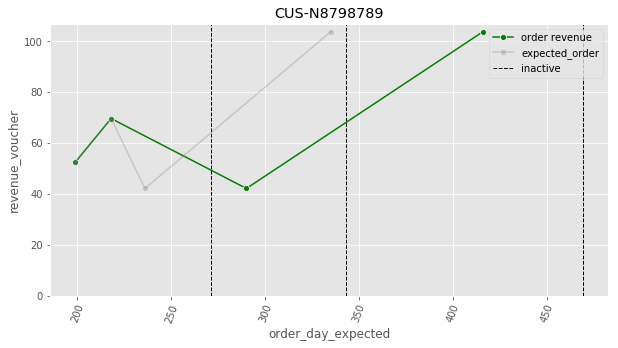

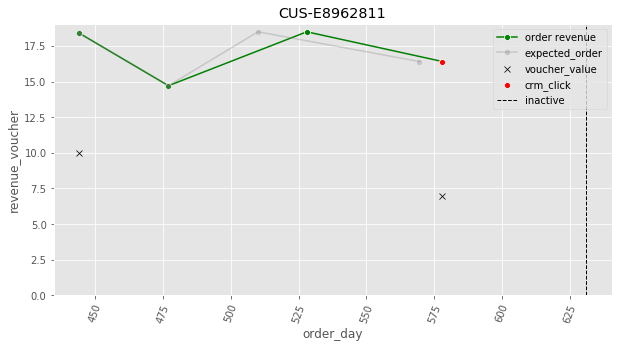

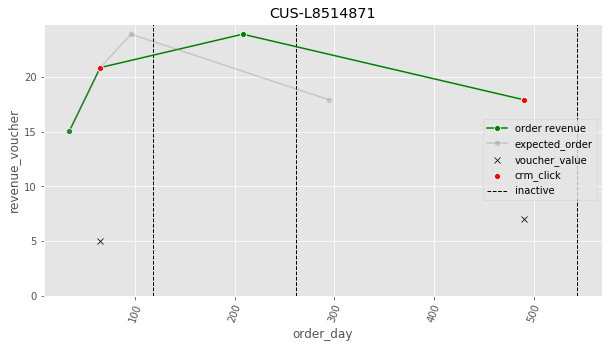

In [18]:
for s in samples:
    plot_customer_lifetime(s)

# Time Prediction Comparison
- How does timing of churn impact if customers return

### Prediction: IOF

count    40514.000000
mean         2.658542
std         49.974405
min       -560.000000
25%         -8.000000
50%          0.000000
75%          9.300000
max        560.000000
Name: order_expected_diff, dtype: float64

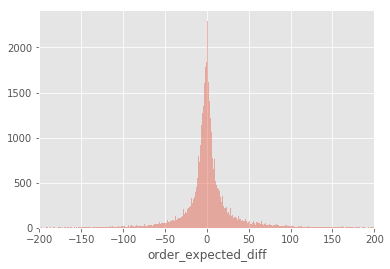

In [19]:
a = df_life.loc[df_life.order_comp_num > 1]
sns.distplot(a.order_expected_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_diff.describe()

In [20]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected)

23.594522853990572

### Prediction: 45 Days

In [21]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected_45)

37.119069951128004

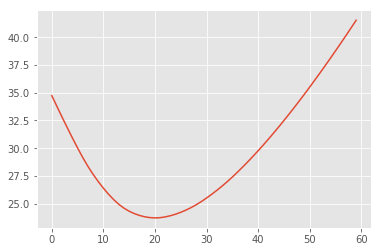

In [22]:
l = []
for d in range(0,60):
    l.append(metrics.mean_absolute_error(a.order_day, a.order_day - a.days_since_last_comp + d))
plt.plot(l)

In [23]:
min(l)

23.71661647825443

count    40514.000000
mean       -17.771437
std         45.514431
min        -53.000000
25%        -41.000000
50%        -32.000000
75%        -13.000000
max        542.000000
Name: order_expected_45_diff, dtype: float64

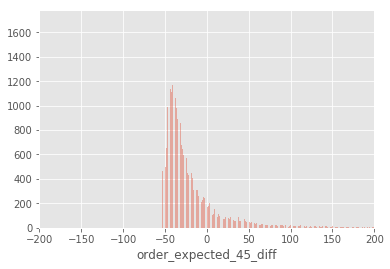

In [24]:
sns.distplot(a.order_expected_45_diff, bins=1000, kde=False)
plt.xlim(-200,200)
a.order_expected_45_diff.describe()

## Group customers based on frequency
- good timing: if frequency 53 (45+8) days +/- 7 days
- soon: if frequency > 53+7
- late: if frequency < 53-7

In [25]:
df_life_2 = df_life.loc[df_life.order_comp_num > 1]
df_life_2['target_timing'] = ['soon' if x >= 53+7 else 'late' if x <= 53-7 else 'correct' for x in df_life_2.frequency]

In [26]:
stats = df_life_2.loc[df_life_2.churned_after].groupby(['target_timing', 'returned'])['order_id'].nunique().reset_index()
stats['target_total'] = stats.groupby('target_timing')['order_id'].transform('sum')
stats['order_perc'] = stats.order_id / stats.target_total

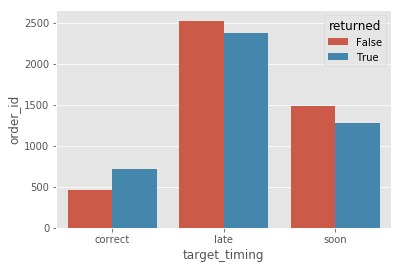

In [27]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned')

# New Customers

In [28]:
df_life0 = df_life.loc[(df_life.order_comp_num == 0) & ~df_life.last_order]
df_life1 = df_life.loc[(df_life.order_comp_num > 0) & ~df_life.last_order]

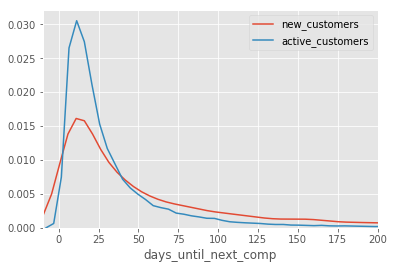

In [29]:
sns.distplot(df_life0.days_until_next_comp, norm_hist=True, hist=False, label='new_customers')
sns.distplot(df_life1.days_until_next_comp, norm_hist=True, hist=False, label='active_customers')
plt.xlim(-10,200)
plt.legend()

In [30]:
df_life0.days_until_next_comp.describe()

count    12593.000000
mean        66.394584
std         85.621369
min          0.000000
25%         13.000000
50%         33.000000
75%         83.000000
max        602.000000
Name: days_until_next_comp, dtype: float64

## Remove Outliers

In [31]:
df_life0 = df_life0.loc[df_life0.days_until_next_comp < 90]
df_life1 = df_life1.loc[df_life1.days_until_next_comp < 90]


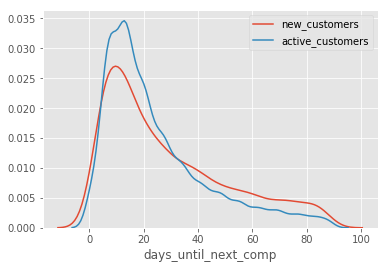

In [32]:
sns.distplot(df_life0.days_until_next_comp, norm_hist=True, hist=False, label='new_customers')
sns.distplot(df_life1.days_until_next_comp, norm_hist=True, hist=False, label='active_customers')
plt.legend()

In [33]:
df_mae_new = pd.Series(index=range(1,60))
df_mae_ret = pd.Series(index=range(1,60))
for days_threshold in range(1,60):
    mae_new = metrics.mean_absolute_error(df_life0.days_until_next_comp, np.ones(len(df_life0)) * days_threshold)
    df_mae_new[days_threshold] = mae_new
    mae_ret = metrics.mean_absolute_error(df_life1.days_until_next_comp, np.ones(len(df_life1)) * days_threshold)
    df_mae_ret[days_threshold] = mae_ret

(0, 37.84805642318255)

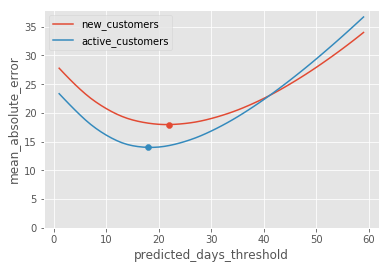

In [34]:
df_mae_new.plot(label='new_customers')
df_mae_ret.plot(label='active_customers')
plt.xlabel('predicted_days_threshold')
plt.ylabel('mean_absolute_error')
plt.scatter(df_mae_new.argmin(), df_mae_new.min())
plt.scatter(df_mae_ret.argmin(), df_mae_ret.min())
plt.legend()
plt.ylim(0)

In [35]:
df_mae_new.argmin(), df_mae_new.min()

(22, 17.971920008289295)

In [36]:
df_mae_new[45]

25.032431872344834

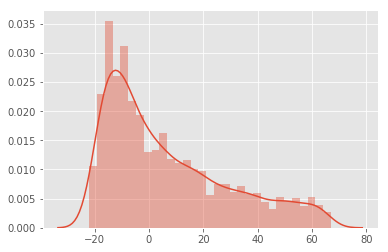

In [37]:
sns.distplot((df_life0.order_day + df_life0.days_until_next_comp) - (df_life0.order_day + 22))

## Find correlated variables

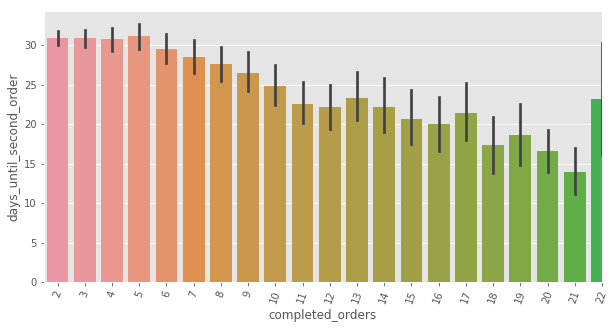

In [38]:
# is the number of days between first and second order representative of number of orders customer will ahve in total
fig = plt.figure(figsize=(10,5))
sns.barplot(data=df_life0, x='completed_orders', y='days_until_next_comp')
plt.xticks(rotation=70)
plt.ylabel('days_until_second_order')
plt.xlim(-0.5,20)
plt.show()

In [153]:
col = 'order_month'

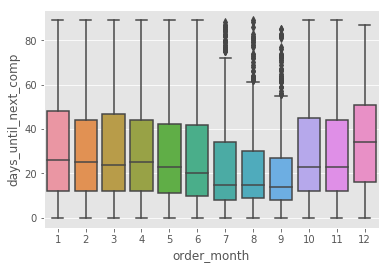

In [154]:
sns.boxplot(data=df_life0, x=col, y='days_until_next_comp')

In [155]:
medians = df_life0.groupby(col).days_until_next_comp.median()
medians

order_month
1     26.0
2     25.0
3     24.0
4     25.0
5     23.0
6     20.0
7     15.0
8     15.0
9     14.0
10    23.0
11    23.0
12    34.0
Name: days_until_next_comp, dtype: float64

In [156]:
metrics.mean_absolute_error(df_life0.days_until_next_comp, medians[df_life0[col].fillna(0)])
# metrics.mean_absolute_error(df_life0.days_until_next_comp, [27 if x == False else 32 for x in df_life0[col]])

17.51828826028391

# Predict days

In [158]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [159]:
pred_cols = ['order_month', 'city']
pred_name = ['days_until_next_comp']
df_pred = df_life0[pred_cols + pred_name]

In [160]:
df_pred['city'] = LabelEncoder().fit_transform(df_pred.city)
# df_pred['service_class'] = LabelEncoder().fit_transform(df_pred.service_class)
# df_pred['voucher_channel'] = LabelEncoder().fit_transform(df_pred.voucher_channel)
# df_pred['final_click_channel'] = LabelEncoder().fit_transform(df_pred.final_click_channel)

In [161]:
df_pred = df_pred.fillna(0)

In [162]:
df_pred.head()

,order_month,city,days_until_next_comp
53773,7,1,7.0
41617,3,2,25.0
23734,8,2,26.0
81161,12,1,59.0
86872,1,1,77.0


In [163]:
X = df_pred[pred_cols].values
y = df_pred[pred_name].values

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test)

(7720, 1931)

In [138]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [139]:
cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=4).mean()

-18.41905459897646

In [140]:
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [141]:
X_train

array([[ 3.        , 15.5       ,  0.        ,  1.        ,  2.        ,
        42.425     ],
       [ 3.        , 10.23809524,  0.7       ,  6.        ,  2.        ,
         5.        ],
       [ 1.        ,  0.        ,  0.5       ,  6.        ,  1.        ,
        12.21993555],
       ...,
       [ 7.        , 14.75      ,  0.        ,  1.        ,  1.        ,
        10.3607089 ],
       [ 4.        , 31.14285714,  0.3       ,  7.        ,  1.        ,
        36.90020519],
       [ 7.        , 20.        ,  0.        ,  7.        ,  1.        ,
         5.12966521]])

In [142]:
X_train_poly

array([[1.00000000e+00, 3.00000000e+00, 1.55000000e+01, ...,
        1.69700000e+02, 3.59976125e+03, 7.63599355e+04],
       [1.00000000e+00, 3.00000000e+00, 1.02380952e+01, ...,
        2.00000000e+01, 5.00000000e+01, 1.25000000e+02],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.22199355e+01, 1.49326825e+02, 1.82476417e+03],
       ...,
       [1.00000000e+00, 7.00000000e+00, 1.47500000e+01, ...,
        1.03607089e+01, 1.07344289e+02, 1.11216293e+03],
       [1.00000000e+00, 4.00000000e+00, 3.11428571e+01, ...,
        3.69002052e+01, 1.36162514e+03, 5.02442472e+04],
       [1.00000000e+00, 7.00000000e+00, 2.00000000e+01, ...,
        5.12966521e+00, 2.63134652e+01, 1.34979267e+02]])

In [143]:
lin_reg.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [144]:
cross_val_score(lin_reg, X_train_poly, y_train, scoring='neg_mean_absolute_error', cv=4).mean()

-18.60703307043332

In [145]:
y_pred = lin_reg.predict(X_test_poly).clip(0, 90)

In [146]:
metrics.mean_absolute_error(y_test, y_pred)

17.750068996844988

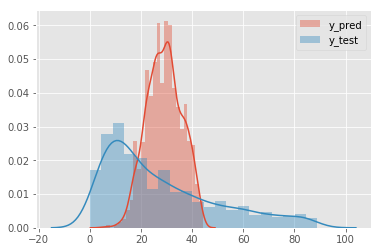

In [115]:
sns.distplot(y_pred, label='y_pred')
sns.distplot(y_test, label='y_test')
plt.legend()

In [58]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,50), learning_rate_init=0.003, learning_rate='adaptive',
                   n_iter_no_change=10, max_iter=200)
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='adaptive',
       learning_rate_init=0.003, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [59]:
cross_val_score(mlp, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()

-17.705169641539175

In [60]:
y_pred = mlp.predict(X_test).clip(0, 90)

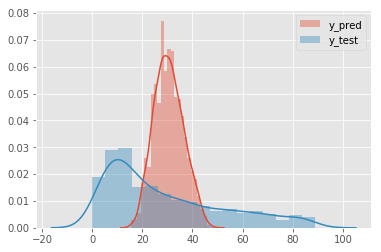

In [61]:
sns.distplot(y_pred, label='y_pred')
sns.distplot(y_test, label='y_test')
plt.legend()

In [62]:
from sklearn.neighbors import KNeighborsRegressor
nei = KNeighborsRegressor()
nei.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [63]:
cross_val_score(nei, X_train, y_train, scoring='neg_mean_absolute_error', cv=4).mean()

-18.651321243523316

# Classification

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [68]:
pred_cols = ['order_month', 'freq_median', 'voucher_ratio', 'order_month', 'cluster']
pred_name = ['weeks_until_next_comp']
df_pred = df_life0[pred_cols + pred_name]

In [69]:
df_pred = df_pred.fillna(0)

In [70]:
X = df_pred[pred_cols].values
y = df_pred[pred_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test)

(7720, 1931)

In [86]:
frst = RandomForestClassifier(max_depth=6)

In [87]:
cross_val_score(frst, X_train, y_train, scoring='neg_mean_absolute_error', cv=4).mean()

-2.8851010860638393

In [92]:
# classifier MLP
cls = MLPClassifier(verbose=False, learning_rate_init=0.002, max_iter=400)
cross_val_score(cls, X_train, y_train, scoring='neg_mean_absolute_error', cv=4).mean()

-2.8416125074579774